In [44]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn import random_projection
import os
from pathlib import Path

#model related
import torch
import torchvision.models as models
from PIL import Image
import seaborn as sns

#statistical test and ploting: 
import time
import pickle

from itertools import combinations

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [45]:
from help_functions import run_sim_on_all_possible_pairs , create_image_matches_dataframe , process_and_extract_activations_from_folder, extract_activations

### parameters 

In [46]:

FULL_PATH_PARENT_FOLDER = Path(r'C:\Users\User\Desktop\human similarity database\all images\mock_dataset')
IMAGES_FOLDER_NAME=FULL_PATH_PARENT_FOLDER.name

# number of matches for top x 
n_match=10

# target image number to compair to for top x 
target_image = 10

# either download or use a pre-downloaded pre-trained model
to_download = True

# to extact activations ?
to_extract = True


### model 

In [18]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if to_download: 
    #download the pretrained model
    vgg16 = models.vgg16(pretrained=True,dropout=0)
    vit_b_16=models.vit_b_16(pretrained=True,dropout=0)
    efficientnet_b7 = models.efficientnet_b7(pretrained=True)
    convnext_base = models.convnext_base(pretrained=True,dropout=0)
    torch.save(vgg16.state_dict(), os.path.join(os.getcwd(),'pre_trained_models','vgg16.pt'))
    torch.save(vit_b_16.state_dict(), os.path.join(os.getcwd(),'pre_trained_models','vit_b_16.pt'))
    torch.save(efficientnet_b7.state_dict(), os.path.join(os.getcwd(), 'pre_trained_models','efficientnet_b7.pt'))
    torch.save(convnext_base.state_dict(),os.path.join(os.getcwd(),'pre_trained_models','convnext_base.pt'))
else: 
    vgg16 = models.vgg16()
    vgg16.load_state_dict(torch.load(os.path.join(os.getcwd(),'pre_trained_models','vgg16.pt')))
    vgg16.eval() 
    vit_b_16 = models.vit_b_16()
    vit_b_16.load_state_dict(torch.load(os.path.join(os.getcwd(),'pre_trained_models','vit_b_16.pt')))
    vit_b_16.eval()
    efficientnet_b7 = models.efficientnet_b7()
    efficientnet_b7.load_state_dict(torch.load(os.path.join(os.getcwd(),'pre_trained_models','efficientnet_b7.pt')))
    efficientnet_b7.eval()
    convnext_base = models.convnext_base()
    convnext_base.load_state_dict(torch.load(os.path.join(os.getcwd(),'pre_trained_models','convnext_base.pt')))
    convnext_base.eval()

#vgg16.to(device)

In [19]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### create baseline layers dictionary 

In [29]:

selected_nodes=['features.4','features.9','features.16','features.23','features.30','classifier.1','classifier.4']
selected_dictionary={node:'level_'+str(i) for i,node in enumerate(selected_nodes)}
selected_dictionary

{'features.4': 'level_0',
 'features.9': 'level_1',
 'features.16': 'level_2',
 'features.23': 'level_3',
 'features.30': 'level_4',
 'classifier.1': 'level_5',
 'classifier.4': 'level_6'}

### extract activations 

In [6]:
# choose to extract activations from layers or use existing activations 
# on the first run - the value needs to be set to 'True'
if to_extract:
    images_info,informative_nodes,informative_nodes_original = process_and_extract_activations_from_folder(FULL_PATH_PARENT_FOLDER,IMAGES_FOLDER_NAME,vgg16,features_dict=selected_dictionary, images_type = 'jpg')
else: 

    file_name = 'images_info_' + IMAGES_FOLDER_NAME +'.csv'
    images_info = pd.read_csv(file_name)

    with open('informative_nodes.pickle', 'rb') as handle:
        informative_nodes = pickle.load(handle)
        informative_nodes_original = pickle.load(handle)


extracting VGG features


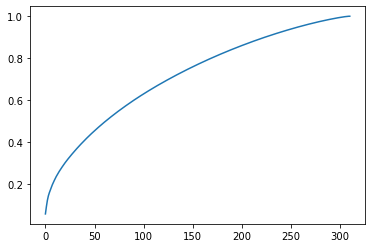

In [10]:
#dekels test: read activations in thier raw form to try dimentionality reduction from activations instead of similarity measures
if True: 
    #read features: 
    all_activations=[]
    for i,img_path in enumerate(images_info['full_path_to_features_VGG'].values):
        im_file = open(img_path, "rb")
        im_features_dict = pickle.load(im_file)
        activations_flattened=im_features_dict['level_0'].flatten()
        activations_flattened=im_features_dict['level_0'].detach().flatten().numpy()
        all_activations.append(activations_flattened)


    #try pca and random projections (not enough images in the mock dataset to extract alot of components... might work better with many more images)
    all_images_activations_matrix=np.vstack([activation for activation in all_activations])
    """
    johnson_lindenstrauss_min_dim(13)
    transformer = random_projection.GaussianRandomProjection()
    X_new = transformer.fit_transform(all_images_activations_matrix)
    """
    pca=PCA()
    trasnformed_X=pca.fit_transform(all_images_activations_matrix)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))

    johnson_lindenstrauss_min_dim(13)
    transformer = random_projection.GaussianRandomProjection(eps=0.5)
    X_new = transformer.fit_transform(all_images_activations_matrix)

### find similarity scores between all pairs 

In [7]:
similarity_df = run_sim_on_all_possible_pairs(FULL_PATH_PARENT_FOLDER,images_info.copy(),informative_nodes,vgg16)


estimated time: first sample took 0.024, all pairs: 48205 is estimated to take 19.163 minutes
 iteration # 500
 iteration # 1000
 iteration # 1500
 iteration # 2000
 iteration # 2500
 iteration # 3000
 iteration # 3500
 iteration # 4000
 iteration # 4500
 iteration # 5000
 iteration # 5500
 iteration # 6000
 iteration # 6500
 iteration # 7000
 iteration # 7500
 iteration # 8000
 iteration # 8500
 iteration # 9000
 iteration # 9500
 iteration # 10000
 iteration # 10500
 iteration # 11000
 iteration # 11500
 iteration # 12000
 iteration # 12500
 iteration # 13000
 iteration # 13500
 iteration # 14000
 iteration # 14500
 iteration # 15000
 iteration # 15500
 iteration # 16000
 iteration # 16500
 iteration # 17000
 iteration # 17500
 iteration # 18000
 iteration # 18500
 iteration # 19000
 iteration # 19500
 iteration # 20000
 iteration # 20500
 iteration # 21000
 iteration # 21500
 iteration # 22000
 iteration # 22500
 iteration # 23000
 iteration # 23500
 iteration # 24000
 iteration # 2

## Top X similar images algorithm

In [35]:

def extract_similarity_contrast_by_layers(similarity_df:pd.DataFrame,layers:list,normalize=True,diagonal_value=100,create_contrast=True):
     #diagonal_value - this defines the value of the diagonal (when the layer is normalized the similarity of an image with itself is an arbitary number)
    if not normalize: 
        diagonal_value=1 #when not normalied, the value of the diagonal is the maximal similarity (1 when using cosine distance) 
    num_layers=len(layers)

    #create a dictionary to map from images names to numbers (so we can work with matrices indexes)
    all_image1=similarity_df['image1'].unique()
    all_image2=similarity_df['image2'].unique()
    all_images=set(np.hstack([all_image1,all_image2]))
    mapping_dict={key:i for i,key in enumerate(all_images)}
    #apply mapping to the similarity_dataframe
    similarity_df['image1_numeric']=similarity_df['image1'].apply(lambda x: mapping_dict[x])
    similarity_df['image2_numeric']=similarity_df['image2'].apply(lambda x: mapping_dict[x])

    #initialize empty matrices
    all_layers_matrices=np.zeros([len(all_images),len(all_images),num_layers])
    contrast_per_layer=np.zeros([num_layers,num_layers])

    #for each desired layer, create an n by n matrix
    for l,layer in enumerate(layers):
        #create a n by n matrix that contains the similairty between each possible image pair: 
        layer_matrix=np.zeros([len(all_images),len(all_images)])*np.nan
        for i,indexes in enumerate(similarity_df[['image1_numeric','image2_numeric']].values):
            if indexes[0]==indexes[1]:
                continue
            else: 
                layer_matrix[indexes[0],indexes[1]]=similarity_df.iloc[i][layer]
                layer_matrix[indexes[1],indexes[0]]=similarity_df.iloc[i][layer]
        
        if normalize: #make sure to not include the diagonal values (which are all maximumally similar) 
            layer_matrix=(layer_matrix-np.nanmean(layer_matrix))/np.nanstd(layer_matrix)
            np.fill_diagonal(layer_matrix, diagonal_value)
            
        all_layers_matrices[:,:,l]=layer_matrix
        if create_contrast: 
            #create the contrast weights: 
            weights=-1*np.ones([1,num_layers])*1/(num_layers-1)
            weights[0,l]=1
            contrast_per_layer[:,l]=weights
        else: #define a contrast matrix that just gives 1 to the relevant layer and to all others (esentialy, no contrast) 
            weights=np.zeros([1,num_layers]) 
            weights[0,l]=1
            contrast_per_layer[:,l]=weights
        


    #multiply the contrasts with the similarity matrix to result in a contrast similarity matrix repsenting the similarity difference (1 vs the mean of all others)
    reshaped_all_layers_matrices=all_layers_matrices.reshape(1,-1,num_layers)
    contrast_similarity_per_layer=np.zeros_like(all_layers_matrices)
    for c in range(num_layers):
        curr_contrast=contrast_per_layer[:,c]
        contrast_similarity_per_layer[:,:,c]=np.sum((reshaped_all_layers_matrices*curr_contrast),axis=-1).reshape(len(all_images),len(all_images))
        np.fill_diagonal(contrast_similarity_per_layer[:,:,c], diagonal_value)
    return_dict={'contrast_similarity_per_layer':contrast_similarity_per_layer,'mapping_dict':mapping_dict,'contrast_per_layer':contrast_per_layer,'all_layers_matrices':all_layers_matrices}   
    return return_dict

In [34]:
def select_similar_subset(contrast_similarity_per_layer:np.array,subset_size:int,seed_type:str ='best', random_selection_order=True):
    contrast_similarity_per_layer_copy=contrast_similarity_per_layer.copy()
    #seed_type - options #['random','best'] (random not implemented yet)
    valid_selection_matrix=np.ones_like(contrast_similarity_per_layer)
    valid_images_for_selection=list(range(contrast_similarity_per_layer.shape[0]))
    #select seed for each layer: 

    seeds_list=[]
    seed_layer_order=list(range(contrast_similarity_per_layer.shape[-1]))
    if random_selection_order:
        seed_layer_order=np.random.permutation(seed_layer_order)

    potential_images=list(range(contrast_similarity_per_layer_copy.shape[0]))
    for l in seed_layer_order:
        if seed_type=='best':
            inds=np.where(contrast_similarity_per_layer_copy[:,:,l]==np.nanmax(contrast_similarity_per_layer_copy[:,:,l]))[0]
        elif seed_type=='random':
            inds=np.random.choice(potential_images,2,replace=False)  
            potential_images=[p_img for p_img in potential_images if p_img not in inds]

        seeds_list.append(inds)
        #make sure that any of the images in this pair can be selected: 
        contrast_similarity_per_layer_copy[inds[0],:,:]=np.nan
        contrast_similarity_per_layer_copy[inds[1],:,:]=np.nan
        contrast_similarity_per_layer_copy[:,inds[0],:]=np.nan
        contrast_similarity_per_layer_copy[:,inds[1],:]=np.nan

        valid_images_for_selection.remove(inds[0])
        valid_images_for_selection.remove(inds[1])

    selection_list=seeds_list.copy()
    #now according to each seed: select for each layer an image that is most similar to the currently selected images: 
    for selection_number in np.arange(2,subset_size):
        iteration_layer_order=list(range(contrast_similarity_per_layer.shape[-1]))
        if random_selection_order:
            iteration_layer_order=np.random.permutation(iteration_layer_order)

        for l in iteration_layer_order: #we might want to premute these numbers to have some randomality in choice order
            all_cells_to_check=[]
            pairs_ids=[]
            for img in selection_list[l]:
                #get similarity with all selected images in the layer: 
                all_pairs_inds=np.array([[img,valid_image] for valid_image in valid_images_for_selection])
                all_pairs_contrast_sims=contrast_similarity_per_layer[:,:,l]
                #get a vector of the similarity values of each remaining img and the selected images
                all_pairs_contrast_sims=contrast_similarity_per_layer[all_pairs_inds[:,0],all_pairs_inds[:,1],l]
                all_cells_to_check.append(all_pairs_contrast_sims)
                pairs_ids.append(all_pairs_inds)
            all_cells_to_check=np.array(all_cells_to_check)
            pairs_ids=np.array(pairs_ids)
            #find the best index
            best_image=np.argmax(np.mean(all_cells_to_check,axis=0))
            true_img_ind=pairs_ids[0,best_image,:][1]
            #add the chosen iamge to the selection list vector: 
            selection_list[l]=np.append(selection_list[l],true_img_ind)
            #remove the imabe from potential images: 
            valid_images_for_selection.remove(true_img_ind)
            #remove similarities (we might not need it)
            contrast_similarity_per_layer_copy[best_image,:,:]=np.nan
            contrast_similarity_per_layer_copy[:,best_image,:]=np.nan
    return selection_list

In [33]:
#calculate paired average per selected images from a layer: 
def calculate_mean_paired_similarity(selected_per_layer,contrast_similarity_per_layer):
    means_per_layer=[]
    for l,img_set in enumerate(selected_per_layer): 
        set_paired_combinations=np.array(list(combinations(img_set,2)))
        layer_all_paired_sim=contrast_similarity_per_layer[set_paired_combinations[:,0],set_paired_combinations[:,1],l]
        mean_layer_all_paired_sim=np.mean(layer_all_paired_sim)
        means_per_layer.append(mean_layer_all_paired_sim)
    return means_per_layer

## PCA 

In [28]:
df_pca = similarity_df.drop(['image1','image2','model','category1','category2'], axis = 1)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents_similarity_vgg = pca.fit_transform(df_pca)
pca_similarity_df = pd.DataFrame(data = principalComponents_similarity_vgg
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

# visualily explore the weights to understand the logic behind the column importance 
weights = pca.components_

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
pca_similarity_df.head(10)

Explained variation per principal component: [5.07437886e-01 4.92552320e-01 5.03106699e-06]


,principal component 1,principal component 2,principal component 3
0,147.039395,35.551253,0.044651
1,143.063136,35.985538,0.451298
2,-7.043865,52.383709,0.315984
3,-8.037995,52.492368,0.025163
4,128.151817,37.614525,0.334635
5,-73.647617,59.659707,0.260484
6,97.335168,40.981015,0.383145
7,54.589465,45.650679,0.435420
8,103.299717,40.329402,0.475670
9,-14.996516,53.252450,0.396574


## normalized differences 

In [29]:
temp_df=similarity_df.copy()
temp_df[[col+'_normed' for col in temp_df.columns if 'level_' in col]]=(temp_df[[col for col in temp_df.columns if 'level_' in col]]-temp_df[[col for col in temp_df.columns if 'level_' in col]].mean(axis=0))/temp_df[[col for col in temp_df.columns if 'level_' in col]].std(axis=0)

temp_df['low_features']=temp_df[['level_'+str(i) for i in np.arange(1,5)]].mean(axis=1)
temp_df['medium_features']=temp_df[['level_'+str(i) for i in np.arange(5,18)]].mean(axis=1)
temp_df['high_features']=temp_df[['level_'+str(i) for i in np.arange(18,21)]].mean(axis=1)


temp_df[['pca_1', 'pca_2','pca_3']]=pca_similarity_df[['principal component 1', 'principal component 2','principal component 3']]

additional_sim_columns=['low_features','medium_features','high_features','diff_1-20','diff_20-1','diff_high-low','diff_low-high']+['pca_1', 'pca_2','pca_3']
normed_sim_columns=[col+'_normed' for col in ['low_features','medium_features','high_features','diff_1-20','diff_20-1','diff_high-low','diff_low-high','diff_medium-high_and_low']]

best_pairs_allinfo_df,best_pairs_allinfo_simvals_df=create_image_matches_dataframe(temp_df,n_match,additional_sim_columns=additional_sim_columns+normed_sim_columns,to_plot=True)

In [28]:
subset_selection_df=similarity_df.copy()

divide_into=3 #define the number of even area segments: 

sim_cumsum=np.cumsum(similarity_df[[col for col in similarity_df.columns if 'level' in col]].mean(axis=0))
cumsum_borders=sim_cumsum.iloc[[0,-1]].values
cumsum_range=cumsum_borders[1]
sub_area_size=cumsum_range/divide_into

levels_per_area=[]
for i in range(divide_into): 
    levels=sim_cumsum[(sim_cumsum>i*sub_area_size) & (sim_cumsum<=(i+1)*sub_area_size)]
    levels_per_area.append(levels)

new_level_names=[]
for i in range(divide_into): 
    cur_levels_names=levels_per_area[i].index
    subset_selection_df['levels_'+cur_levels_names[0].split('_')[-1]+'_'+cur_levels_names[-1].split('_')[-1]]=subset_selection_df[cur_levels_names].mean(axis=1)
    new_level_names.append('levels_'+cur_levels_names[0].split('_')[-1]+'_'+cur_levels_names[-1].split('_')[-1])



In [184]:
#extract subset of similar layer based on the averaged similarities: 
to_plot=False
all_selected_per_layer_per_contrast_type=[]
all_mean_sim_vals_per_contrast_type=[]
for contrast in [True]:#,False]:
    all_selected_per_layer=[]
    all_mean_sim_vals=[]
    for i in range(200):
        starttime=time.time()
        #layers_for_extraction=['low_features_normed','medium_features_normed','high_features_normed'] #defines which layers to extract image similairty 
        layers_for_extraction=new_level_names
        subset_size=20
        
        return_dict=extract_similarity_contrast_by_layers(subset_selection_df,layers=layers_for_extraction,normalize=True,diagonal_value=np.nan,create_contrast=contrast)
        contrast_similarity_per_layer=return_dict['contrast_similarity_per_layer']
        mapping_dict=return_dict['mapping_dict']
        contrast_per_layer=return_dict['contrast_per_layer']
        all_layers_matrices=return_dict['all_layers_matrices']

        #select the best images: 
        selected_per_layer=select_similar_subset(contrast_similarity_per_layer=contrast_similarity_per_layer,subset_size=subset_size,seed_type = 'random',random_selection_order=True)

        #plot the selected images based on the requested layers
        if to_plot: 
            fig, ax = plt.subplots(nrows=len(selected_per_layer),ncols=len(selected_per_layer[0]),figsize=(10,10),sharex=True,sharey=True)
            #convert_back_to_img_identities and plot the images: 
            reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('pkl','jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
            for l,selected_images in enumerate(selected_per_layer): 
                selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
                #plot the image in one column: 

                paths = selected_images_paths        
                #print(y)
                ax[l,0].set_ylabel(layers_for_extraction[l])
                for col,cur_img_path in enumerate(paths): 
                    cur_img=Image.open(cur_img_path)
                    ax[l,col].imshow(cur_img)
                    ax[l,col].set_xticks([])
                    ax[l,col].set_yticks([])
                    
            fig.patch.set_facecolor('xkcd:mint green')
            fig.tight_layout()

        mean_sim_values=calculate_mean_paired_similarity(selected_per_layer,contrast_similarity_per_layer)

        all_mean_sim_vals.append(mean_sim_values)
        all_selected_per_layer.append(selected_per_layer)
        endtime=time.time()
        print(f'trial duration: {i}',endtime-starttime)
    #save the contrast condition in higher order list:     
    all_selected_per_layer_per_contrast_type.append(all_selected_per_layer)
    all_mean_sim_vals_per_contrast_type.append(all_mean_sim_vals)


trial duration: 0 21.62164044380188
trial duration: 1 21.51598358154297
trial duration: 2 21.461097955703735
trial duration: 3 21.379297256469727
trial duration: 4 21.486663103103638
trial duration: 5 21.955284595489502
trial duration: 6 21.590599536895752
trial duration: 7 21.413489818572998
trial duration: 8 21.63948392868042
trial duration: 9 21.56078052520752
trial duration: 10 21.73608136177063
trial duration: 11 21.358636140823364
trial duration: 12 21.54200267791748
trial duration: 13 21.281820058822632
trial duration: 14 21.32341980934143
trial duration: 15 21.271960258483887
trial duration: 16 21.260251760482788
trial duration: 17 21.3438880443573
trial duration: 18 21.262531757354736
trial duration: 19 21.36112141609192
trial duration: 20 21.748096227645874
trial duration: 21 21.338871240615845
trial duration: 22 21.57462739944458
trial duration: 23 21.398933172225952
trial duration: 24 21.322653770446777
trial duration: 25 21.333673238754272
trial duration: 26 21.25482487678

In [186]:
#save results with pickle:
save_dict={'all_selected_per_layer_per_contrast_type':all_selected_per_layer_per_contrast_type,'all_mean_sim_vals_per_contrast_type':all_mean_sim_vals_per_contrast_type}
with open('random_200_iterations_saved_dict.pkl','wb') as handle:
    pickle.dump(save_dict,handle)


with open('random_200_iterations_two_seperated_dumps.pkl','wb') as handle:
    pickle.dump(all_selected_per_layer_per_contrast_type,handle)
    pickle.dump(all_mean_sim_vals_per_contrast_type,handle)


In [175]:
all_data=[]
with open('random_1000_iterations.pkl','rb') as f:
    all_selected_per_layer_per_contrast_type=pickle.load(f)
    all_mean_sim_vals_per_contrast_type=pickle.load(f)



      

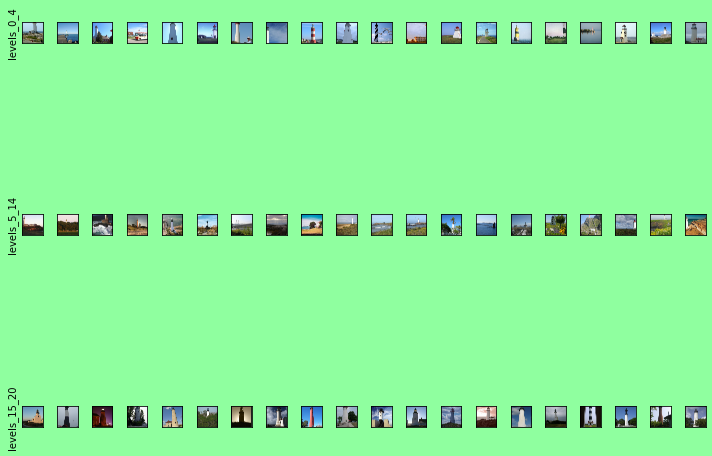

In [187]:

all_selected_per_layer=all_selected_per_layer_per_contrast_type[0]
all_mean_sim_vals=all_mean_sim_vals_per_contrast_type[0]

best_iteration_ind=np.argmax(np.mean(all_mean_sim_vals,axis=1))
selected_per_layer=all_selected_per_layer[best_iteration_ind]

fig, ax = plt.subplots(nrows=len(selected_per_layer),ncols=len(selected_per_layer[0]),figsize=(10,10),sharex=True,sharey=True)
#convert_back_to_img_identities and plot the images: 
reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('pkl','jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
images_names=[]
for l,selected_images in enumerate(selected_per_layer): 
    selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
    selected_images_names=[os.path.basename(selected_images_path).replace('jpg','pkl') for selected_images_path in selected_images_paths]
    #plot the image in one column: 
    images_names.append(selected_images_names)
    paths = selected_images_paths        
    #print(y)
    ax[l,0].set_ylabel(layers_for_extraction[l])
    for col,cur_img_path in enumerate(paths): 
        cur_img=Image.open(cur_img_path)
        ax[l,col].imshow(cur_img)
        ax[l,col].set_xticks([])
        ax[l,col].set_yticks([])
        
fig.patch.set_facecolor('xkcd:mint green')
fig.tight_layout()


## saving selected images to folder 


In [222]:
# saving the selected images to subfolder 
# outputs folder name 
output_folder_name = IMAGES_FOLDER_NAME + '_' + 'selected_final_images'
# create the outputs folder 
outputs_folder_location = os.path.join(os.path.dirname(FULL_PATH_PARENT_FOLDER),(IMAGES_FOLDER_NAME + '_' + 'selected_final_images'))
if os.path.isdir(outputs_folder_location):
    pass 
else: 
    os.makedirs(outputs_folder_location)

for l,selected_images in enumerate(selected_per_layer): 
    # subfolder name 
    subfolder_name = f'layer_{l}'
    # subfolder location 
    subfolder_location = os.path.join(outputs_folder_location,subfolder_name)
    # create new subfolder 
    os.makedirs(subfolder_location)

    # all of the images paths 
    selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
    # all images names 
    selected_images_names=[os.path.basename(selected_images_path) for selected_images_path in selected_images_paths]

    for i, image in enumerate(selected_images_paths):

        img = Image.open(image)
        name = selected_images_names[i]
        full_path = os.path.join(subfolder_location,name)

        img.save(full_path)



In [189]:

relevant_images_names_for_similarity_df=np.array(images_names).flatten()
new_df=pd.DataFrame()

for i,(img1,img2) in enumerate(similarity_df[['image1','image2']].values): 
    if (img1 in relevant_images_names_for_similarity_df) and (img2 in relevant_images_names_for_similarity_df):
        new_df=pd.concat([new_df,pd.DataFrame(similarity_df.iloc[i])],ignore_index=True, axis=1)

In [190]:
def get_RDM_from_layer(sim_df,layer,diagonal_default=0):
    #this function expects a similarity dataframe (with 2 columns: image1 and image2 - which represents the name of the images in the pair
    # and other columns that represent the level of comparison)
    #example datA:  image1,image2,level_0,level_1
            #       test1 ,test2 ,0.5    ,0.1
            #       test3 ,test1 ,0.7    ,0.3
            #       test2 ,test3 ,0.6    ,0.2

    #it will return the layer_RDM which is an nxn matrix of dissimaltiry numbers (diagonal is default to 0)
    
    #get all unique image names
    all_images_in_the_paired_df=list(set(list(sim_df['image1'].unique())+list(sim_df['image2'].unique())))

    #create a dictionry to convert from names to numbers (and the opposite when returning the function)
    string_to_num_dictionary={key:val for val,key in enumerate(all_images_in_the_paired_df)}
    #rename the images to numeric values to speed up the comparisons
    sim_df['image1_numeric']=[string_to_num_dictionary[imgname] for imgname in sim_df['image1']]
    sim_df['image2_numeric']=[string_to_num_dictionary[imgname] for imgname in sim_df['image2']]
    all_images_in_the_paired_df=list(set(list(sim_df['image1_numeric'].unique())+list(sim_df['image2_numeric'].unique())))

    layer_RDM=np.zeros([len(all_images_in_the_paired_df),len(all_images_in_the_paired_df)])
    for i,im1 in enumerate(all_images_in_the_paired_df):
        for j,im2 in enumerate(all_images_in_the_paired_df):

            if i==1 and j==2: 
                start=time.time()

            if im1==im2:
                dissimilarity_val=diagonal_default
            else: 
                dissimilarity_val=sim_df.loc[(sim_df['image1_numeric']==im1) & (sim_df['image2_numeric']==im2) | (sim_df['image1_numeric']==im2) & (sim_df['image2_numeric']==im1),layer].values[0]
            layer_RDM[i,j]=dissimilarity_val

            if i==1 and j==2: 
                end=time.time()
                iteration_runtime=end-start
                all_iterations=len(all_images_in_the_paired_df) * len(all_images_in_the_paired_df)
                overall_estimate=iteration_runtime * all_iterations
                print(f'iteration duration: {iteration_runtime} [s], estimated runtime for all {all_iterations} = {overall_estimate/60} [m]')
    #create layer dataframe with original names: 
    num_to_string_dictionar={val:key for key,val in string_to_num_dictionary.items()}
    images_names_by_numeric_order=[num_to_string_dictionar[num] for num in range(len(all_images_in_the_paired_df))]
    layer_RDM_df=pd.DataFrame(data = layer_RDM, columns=images_names_by_numeric_order, index=images_names_by_numeric_order )            
    return layer_RDM,layer_RDM_df


create the RDM of the dataset - on every informative layer + averaged layers

In [191]:

create_RDM=True

if create_RDM:
    df_all_levels_rdm=pd.DataFrame()
    levels=[col for col in new_df.T.columns if 'level' in col]  
    for level in levels: 
        _,layer_df=get_RDM_from_layer(new_df.T.copy(),level)
        ordered_layer_df=pd.DataFrame()
        for i,img in enumerate(relevant_images_names_for_similarity_df):
            ordered_layer_df=pd.concat([ordered_layer_df,layer_df.loc[img,relevant_images_names_for_similarity_df]],axis=1)

        
        ordered_layer_df['rep_level']=level
        df_all_levels_rdm=pd.concat([df_all_levels_rdm,ordered_layer_df],axis=0)
    df_all_levels_rdm.to_csv('all_RDMs.csv',index=False)    
else:
    df_all_levels_rdm=pd.read_csv('all_RDMs.csv')

iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0010080337524414062 [s], estimated runtime for all 3600 = 0.060482025146484375 [m]
iteration duration: 0.0009992122650146484 [s], estimated runtime for all 3600 = 0.059952735900878906 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.000997304916381836 [s], estimated runtime for all 3600 = 0.059838294982910156 [m]
iteration duration: 0.0009961128234863281 [s], estimated runtime for all 3600 = 0.05976676940917969 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0009970664978027344 [s], estimated runtime for all 3600 = 0.05982398986816406 [m]
iteration duration: 0.0009975433349609375 [s], estimated r

In [192]:
df_all_levels_rdm
df_all_levels_rdm['rep_level'].unique()
rel = ['level_0', 'level_1', 'level_2', 'level_3', 'level_4', 'level_5',
       'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11',
       'level_12', 'level_13', 'level_14', 'level_15', 'level_16',
       'level_17', 'level_18', 'level_19', 'level_20', 'level_21']


In [193]:
df_all_levels_rdm

,sun_apbccsxojfkifmgr.pkl,sun_aqkdkqjtpkizuqeu.pkl,sun_aikuhqlfaxsyenoq.pkl,sun_amodzdpwuezketui.pkl,sun_alguuwceyzjhcqbe.pkl,sun_agynxcbzsafumezy.pkl,sun_aqpphhufllwhjato.pkl,sun_aatywrsbdbluavkj.pkl,sun_axoajgjdxmnclxac.pkl,sun_ahbqofdeagteacfd.pkl,...,sun_aazgsatywaxsgwlw.pkl,sun_aeuuomososlobnbc.pkl,sun_atnidvxkujtznltb.pkl,sun_arhsbjwsqburhqql.pkl,sun_aewtvpwulyxhqvuv.pkl,sun_ascxreypwxqkzarj.pkl,sun_azmhranexvijzcyp.pkl,sun_avsundisdtqghxtb.pkl,sun_aqcwujkqbswhreik.pkl,rep_level
sun_apbccsxojfkifmgr.pkl,0.000000,0.512317,0.525916,0.484058,0.404929,0.396552,0.247551,-0.016238,0.383008,0.486835,...,0.357600,0.365358,0.645001,-0.062422,0.597353,-0.063906,0.172844,0.444150,0.345646,level_0
sun_aqkdkqjtpkizuqeu.pkl,0.512317,0.000000,0.757815,0.649779,0.618596,0.795365,0.579557,0.462830,0.658249,0.694920,...,0.595559,0.557778,0.563431,0.196684,0.561846,0.144100,0.416360,0.477181,0.532463,level_0
sun_aikuhqlfaxsyenoq.pkl,0.525916,0.757815,0.000000,0.530987,0.468762,0.713071,0.424024,0.338332,0.541881,0.590398,...,0.509270,0.508070,0.524192,0.129311,0.598786,0.127378,0.446591,0.411352,0.511186,level_0
sun_amodzdpwuezketui.pkl,0.484058,0.649779,0.530987,0.000000,0.675704,0.577704,0.551350,0.419205,0.618948,0.646108,...,0.380069,0.318508,0.391074,0.155516,0.276792,0.032405,0.122257,0.329359,0.191094,level_0
sun_alguuwceyzjhcqbe.pkl,0.404929,0.618596,0.468762,0.675704,0.000000,0.564192,0.707143,0.624004,0.757093,0.811965,...,0.525858,0.522191,0.290166,0.073020,0.193773,-0.104375,0.047702,0.380372,0.066868,level_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sun_aewtvpwulyxhqvuv.pkl,0.709610,0.711318,0.889686,0.427423,0.792620,0.911570,0.844627,0.875902,0.902611,0.865347,...,0.846068,0.887427,0.874283,0.862310,0.000000,0.894193,0.909380,0.843989,0.917310,level_21
sun_ascxreypwxqkzarj.pkl,0.688014,0.717071,0.841249,0.483697,0.824849,0.845987,0.828911,0.884128,0.884534,0.845553,...,0.811898,0.824681,0.806420,0.911922,0.894193,0.000000,0.888524,0.864716,0.908305,level_21
sun_azmhranexvijzcyp.pkl,0.837834,0.805289,0.886942,0.474959,0.832046,0.856558,0.945372,0.877757,0.923121,0.861053,...,0.878683,0.890131,0.880824,0.920120,0.909380,0.888524,0.000000,0.887622,0.926933,level_21
sun_avsundisdtqghxtb.pkl,0.790319,0.693691,0.885934,0.409460,0.808418,0.794839,0.868112,0.794263,0.803912,0.808470,...,0.835489,0.819887,0.829964,0.890810,0.843989,0.864716,0.887622,0.000000,0.910063,level_21


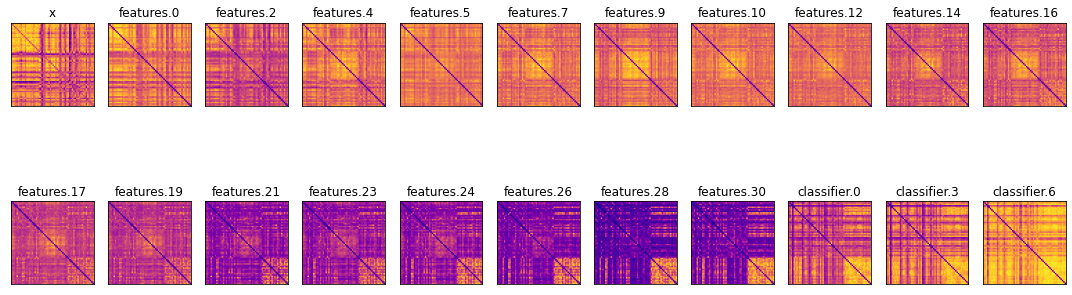

In [194]:
#this cell create a 5 by 5 subplot figure of the RDM based on the network representation layers (note that if more than 25 exists, this code should be modified)
# TODO : this code needs to be modified to fit any shape of data 

fig,axes=plt.subplots(nrows=2,ncols=11,figsize=(15,6))
min=df_all_levels_rdm.min()
max=df_all_levels_rdm.max()
for i,level in enumerate(rel):
    if i <= 10:
        cols = i 
        rows = 0
    else:
        cols = i - 11
        rows = 1

    
    cur_df=df_all_levels_rdm.loc[df_all_levels_rdm['rep_level']==level].copy()
    cur_df.drop(columns='rep_level',inplace=True)
    im=axes[rows,cols].imshow(cur_df.values, cmap='plasma')
    axes[rows,cols].set_title(list(informative_nodes_original.keys())[i])
    axes[rows,cols].set_xticks([])
    axes[rows,cols].set_yticks([])

fig.tight_layout()
fig.patch.set_facecolor('white')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\human similarity database\\all images\\mock_dataset\\lighthouse\\0149.jpg'

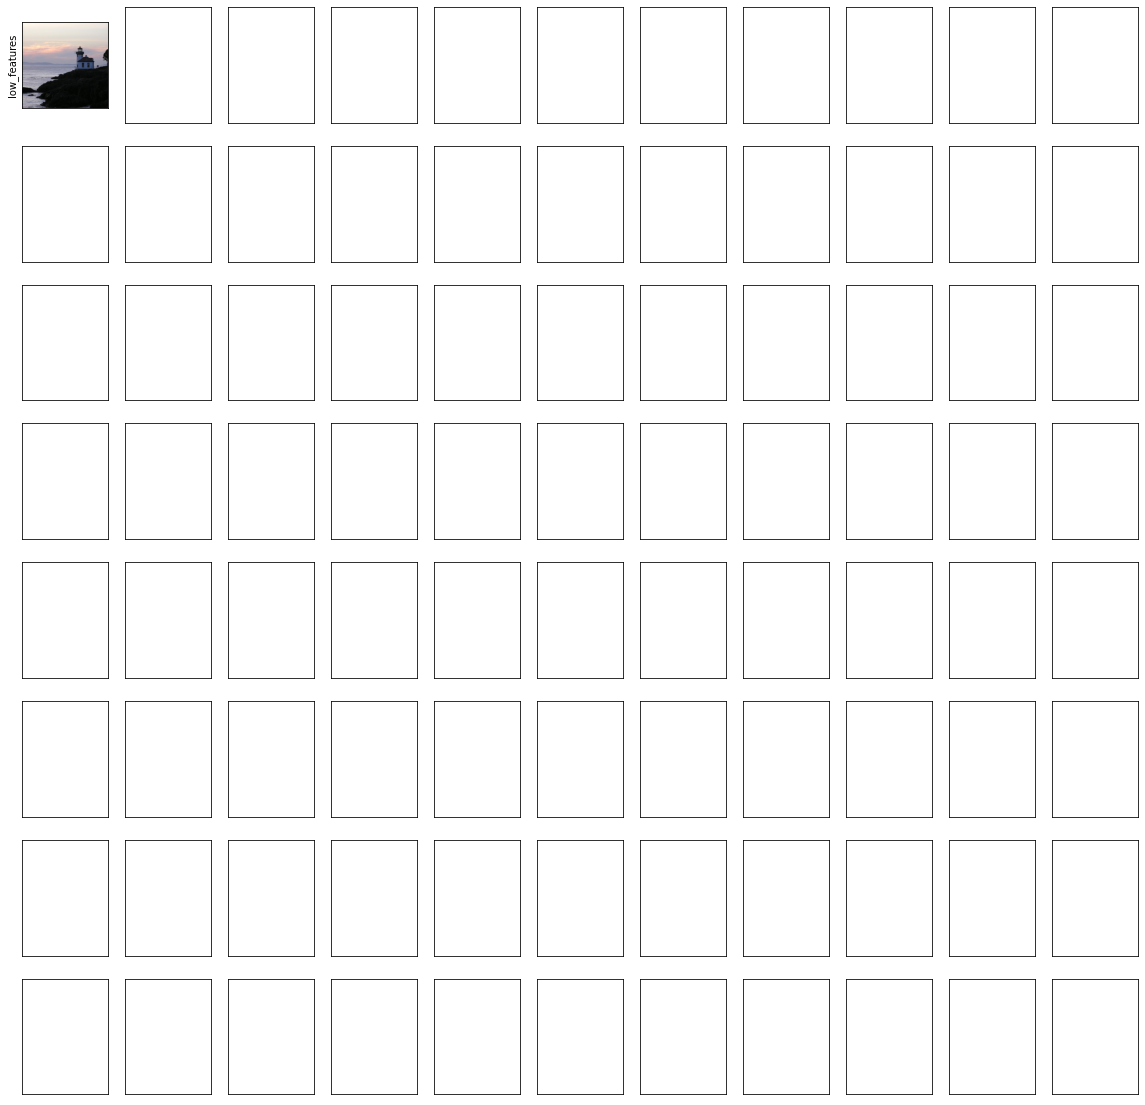

In [68]:
sim_level_cols=['low_features','medium_features','high_features','diff_high-low','diff_low-high','diff_high-low_normed','diff_low-high_normed','diff_medium-high_and_low_normed']
fig,axes=plt.subplots(nrows=len(sim_level_cols),ncols=n_match+1,figsize=(20,20),sharex=True,sharey=True)
fig.patch.set_facecolor('xkcd:white')
for imgname in [best_pairs_allinfo_df.index[target_image]]:
    for rownum,sim_level_col in enumerate(sim_level_cols): 
        refernce_image=images_info.loc[images_info['img_name']==imgname.replace('pkl','jpg'),'full_path_to_img'].values[0]
        path_to_category=refernce_image.replace(imgname.replace('pkl','jpg'),'')
        matches_list=best_pairs_allinfo_df.loc[imgname,sim_level_col]
        sim_list=best_pairs_allinfo_simvals_df.loc[imgname,sim_level_col]
        ref_img=Image.open(refernce_image)
        axes[rownum,0].imshow(np.real(ref_img))
        axes[rownum,0].set_xticklabels('')
        axes[rownum,0].set_xticks([])
        axes[rownum,0].set_yticks([])
        axes[rownum,0].set_yticklabels('')
        axes[rownum,0].set_ylabel(sim_level_col)
        for colnum,match_img in enumerate(matches_list): 
            match_img=Image.open(os.path.join(path_to_category,match_img.replace('pkl','jpg')))
            axes[rownum,colnum+1].imshow(np.real(match_img))
            axes[rownum,colnum+1].set_xticklabels('')
            axes[rownum,colnum+1].set_xticks([])
            axes[rownum,colnum+1].set_yticks([])
            axes[rownum,colnum+1].set_yticklabels('')
            axes[rownum,colnum+1].set_title(sim_list[colnum])